##Reguralization and Global Average Pooling

# Import Libraries

In [60]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [61]:
#import Network from model.py
from model import Net

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [62]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [63]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [64]:
SEED = 4

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(2.7306)
 - std: tensor(0.5295)
 - var: tensor(0.2804)
torch.Size([64, 1, 28, 28])
torch.Size([64])


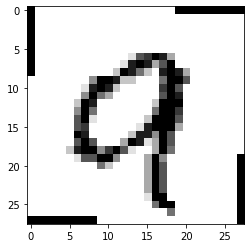

In [65]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

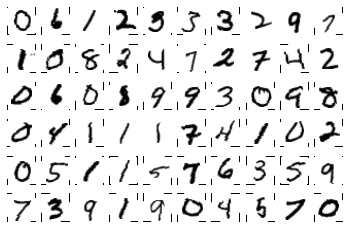

In [66]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

## case 1: Layer Normalization

In [67]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
Num_of_groups=2 #here we are defining the number of groups for group normalization.
# batchnorm=nn.BatchNorm2d
# layernorm=nn.LayerNorm

norm=input("enter type of normalization") # enter the type of Normalization : layer,batch, group normalization

model_layer = Net(norm,Num_of_groups).to(device) #layer normalization model


#elif norm==layernorm:
#norm=nn.LayerNorm
#model = Net(norm,Num_of_groups).to(device)
summary(model_layer, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
enter type of normalizationlayer
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         LayerNorm-3           [-1, 16, 26, 26]          21,632
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
         LayerNorm-7           [-1, 32, 24, 24]          36,864
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [68]:
from tqdm import tqdm

train_losses_layer = []
test_losses_layer = []
train_acc_layer = []
test_acc_layer = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_layer.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_layer.append(100*correct/processed)



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_layer.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_layer.append(100. * correct / len(test_loader.dataset))
  

# Let's Train and test our model

In [69]:
from torch.optim.lr_scheduler import StepLR
model_layer = Net(norm,Num_of_groups).to(device)
#model =  Net().to(device)
optimizer = optim.SGD(model_layer.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_layer, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_layer, device, test_loader)

EPOCH: 0


Loss=0.09088067710399628 Batch_id=937 Accuracy=89.58: 100%|██████████| 938/938 [01:54<00:00,  8.21it/s]



Test set: Average loss: 0.0812, Accuracy: 9804/10000 (98.04%)

EPOCH: 1


Loss=0.04937582463026047 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [01:48<00:00,  8.63it/s]



Test set: Average loss: 0.0439, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.011784186586737633 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [01:48<00:00,  8.63it/s]



Test set: Average loss: 0.0333, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


Loss=0.006317661143839359 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [01:47<00:00,  8.76it/s]



Test set: Average loss: 0.0325, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.013938477262854576 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:45<00:00,  8.92it/s]



Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.005828073248267174 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [01:45<00:00,  8.87it/s]



Test set: Average loss: 0.0295, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.0185350701212883 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [01:56<00:00,  8.02it/s]



Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 7


Loss=0.016629312187433243 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:55<00:00,  8.14it/s]



Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.012266717851161957 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]



Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.088536337018013 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:57<00:00,  7.95it/s]



Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.017597103491425514 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:54<00:00,  8.22it/s]



Test set: Average loss: 0.0227, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.056656863540410995 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:46<00:00,  8.77it/s]



Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.1208144873380661 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [01:46<00:00,  8.82it/s]



Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.0838984027504921 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [01:49<00:00,  8.56it/s]



Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.0032495202030986547 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [01:50<00:00,  8.49it/s]



Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.006025365088135004 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [02:02<00:00,  7.69it/s]



Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.04849492385983467 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:51<00:00,  8.42it/s]



Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.01023523136973381 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [01:52<00:00,  8.36it/s]



Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.0022138222120702267 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [01:55<00:00,  8.12it/s]



Test set: Average loss: 0.0215, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.016817579045891762 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [02:05<00:00,  7.49it/s]



Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)



## case 2: Group normalization

In [70]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
Num_of_groups=2 #here we are defining the number of groups for group normalization.
# batchnorm=nn.BatchNorm2d
# layernorm=nn.LayerNorm

norm=input("enter type of normalization") # enter the type of Normalization : layer,batch, group normalization

model_group = Net(norm,Num_of_groups).to(device) #layer normalization model

#elif norm==layernorm:
#norm=nn.LayerNorm
#model = Net(norm,Num_of_groups).to(device)
summary(model_group, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
enter type of normalizationgroup
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
         GroupNorm-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           

In [71]:
from tqdm import tqdm

train_losses_group = []
test_losses_group = []
train_acc_group = []
test_acc_group = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_group.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_group.append(100*correct/processed)



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_group.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_group.append(100. * correct / len(test_loader.dataset))
  

In [72]:
from torch.optim.lr_scheduler import StepLR
model_group = Net(norm,Num_of_groups).to(device)
#model =  Net().to(device)
optimizer = optim.SGD(model_group.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_group, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_group, device, test_loader)

EPOCH: 0


Loss=0.1520356386899948 Batch_id=937 Accuracy=89.06: 100%|██████████| 938/938 [02:14<00:00,  6.95it/s]



Test set: Average loss: 0.0597, Accuracy: 9839/10000 (98.39%)

EPOCH: 1


Loss=0.258910208940506 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [01:50<00:00,  8.50it/s]



Test set: Average loss: 0.0502, Accuracy: 9847/10000 (98.47%)

EPOCH: 2


Loss=0.015369240194559097 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [01:46<00:00,  8.78it/s]



Test set: Average loss: 0.0350, Accuracy: 9894/10000 (98.94%)

EPOCH: 3


Loss=0.008664144203066826 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [01:41<00:00,  9.22it/s]



Test set: Average loss: 0.0314, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.14709027111530304 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [01:40<00:00,  9.33it/s]



Test set: Average loss: 0.0275, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.10723686218261719 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [01:42<00:00,  9.13it/s]



Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.012455947697162628 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:41<00:00,  9.28it/s]



Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.1031138226389885 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [01:41<00:00,  9.25it/s]



Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.09174425899982452 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [01:42<00:00,  9.16it/s]



Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.004252301063388586 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:44<00:00,  8.99it/s]



Test set: Average loss: 0.0206, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.027936719357967377 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [01:45<00:00,  8.90it/s]



Test set: Average loss: 0.0210, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.04628343507647514 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [01:44<00:00,  9.00it/s]



Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.12409161031246185 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:45<00:00,  8.88it/s]



Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.0621420294046402 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:46<00:00,  8.84it/s]



Test set: Average loss: 0.0207, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.07428907603025436 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:45<00:00,  8.90it/s]



Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.001974040875211358 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [01:44<00:00,  8.97it/s]



Test set: Average loss: 0.0204, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.00489057507365942 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:45<00:00,  8.87it/s]



Test set: Average loss: 0.0204, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.0009743385598994792 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:45<00:00,  8.92it/s]



Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.023592794314026833 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [01:45<00:00,  8.90it/s]



Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.013360586017370224 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:49<00:00,  8.59it/s]



Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)



## case 3: L1+ BN

In [73]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
Num_of_groups=2 #here we are defining the number of groups for group normalization.
# batchnorm=nn.BatchNorm2d
# layernorm=nn.LayerNorm

norm=input("enter type of normalization") # enter the type of Normalization : layer,batch, group normalization

model_batch = Net(norm,Num_of_groups).to(device) #layer normalization model

#elif norm==layernorm:
#norm=nn.LayerNorm
#model = Net(norm,Num_of_groups).to(device)
summary(model_batch, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
enter type of normalizationbatch
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           

In [74]:
from tqdm import tqdm

train_losses_batch = []
test_losses_batch = []
train_acc_batch = []
test_acc_batch = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    lambda_l1=0.01
    # Calculate loss
    # print("pred",y_pred.shape)
    # print("actual",target.shape)
    loss = F.nll_loss(y_pred,target)
    l1=0
    for p in model.parameters():
      l1=l1+p.abs().sum()
    loss=loss+lambda_l1*l1

    train_losses_batch.append(loss)
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_batch.append(100*correct/processed)



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_batch.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_batch.append(100. * correct / len(test_loader.dataset))
  

In [ ]:
from torch.optim.lr_scheduler import StepLR
model_batch = Net(norm,Num_of_groups).to(device)
#model =  Net().to(device)
optimizer = optim.SGD(model_batch.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_batch, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model_batch, device, test_loader)

EPOCH: 0


Loss=1.6265878677368164 Batch_id=937 Accuracy=84.99: 100%|██████████| 938/938 [02:03<00:00,  7.60it/s]



Test set: Average loss: 0.3985, Accuracy: 9094/10000 (90.94%)

EPOCH: 1


Loss=1.2756547927856445 Batch_id=937 Accuracy=89.70: 100%|██████████| 938/938 [02:06<00:00,  7.43it/s]



Test set: Average loss: 0.4526, Accuracy: 8800/10000 (88.00%)

EPOCH: 2


Loss=1.4974164962768555 Batch_id=937 Accuracy=89.63: 100%|██████████| 938/938 [02:01<00:00,  7.74it/s]



Test set: Average loss: 0.7958, Accuracy: 7020/10000 (70.20%)

EPOCH: 3


Loss=1.4511100053787231 Batch_id=937 Accuracy=90.18: 100%|██████████| 938/938 [02:05<00:00,  7.44it/s]



Test set: Average loss: 0.7005, Accuracy: 7648/10000 (76.48%)

EPOCH: 4


Loss=1.277151107788086 Batch_id=937 Accuracy=89.98: 100%|██████████| 938/938 [02:03<00:00,  7.59it/s]



Test set: Average loss: 1.1657, Accuracy: 6469/10000 (64.69%)

EPOCH: 5


Loss=1.3633962869644165 Batch_id=937 Accuracy=89.70: 100%|██████████| 938/938 [02:05<00:00,  7.49it/s]



Test set: Average loss: 0.5184, Accuracy: 8320/10000 (83.20%)

EPOCH: 6


Loss=0.7917841672897339 Batch_id=937 Accuracy=94.42: 100%|██████████| 938/938 [01:56<00:00,  8.03it/s]



Test set: Average loss: 0.1964, Accuracy: 9461/10000 (94.61%)

EPOCH: 7


Loss=0.8658396601676941 Batch_id=937 Accuracy=94.27: 100%|██████████| 938/938 [01:59<00:00,  7.86it/s]



Test set: Average loss: 0.1985, Accuracy: 9457/10000 (94.57%)

EPOCH: 8


Loss=0.8301934003829956 Batch_id=937 Accuracy=94.12: 100%|██████████| 938/938 [02:05<00:00,  7.47it/s]



Test set: Average loss: 0.2791, Accuracy: 9160/10000 (91.60%)

EPOCH: 9


Loss=1.0106650590896606 Batch_id=937 Accuracy=94.11: 100%|██████████| 938/938 [02:01<00:00,  7.71it/s]



Test set: Average loss: 0.2587, Accuracy: 9237/10000 (92.37%)

EPOCH: 10


Loss=0.7835798859596252 Batch_id=937 Accuracy=94.25: 100%|██████████| 938/938 [01:55<00:00,  8.15it/s]



Test set: Average loss: 0.1632, Accuracy: 9535/10000 (95.35%)

EPOCH: 11


Loss=0.7741174697875977 Batch_id=937 Accuracy=94.05: 100%|██████████| 938/938 [01:51<00:00,  8.45it/s]



Test set: Average loss: 0.1875, Accuracy: 9449/10000 (94.49%)

EPOCH: 12


Loss=0.6683734655380249 Batch_id=937 Accuracy=96.32: 100%|██████████| 938/938 [01:54<00:00,  8.23it/s]



Test set: Average loss: 0.0958, Accuracy: 9751/10000 (97.51%)

EPOCH: 13


Loss=0.6939823627471924 Batch_id=937 Accuracy=96.40: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]



Test set: Average loss: 0.1096, Accuracy: 9713/10000 (97.13%)

EPOCH: 14


Loss=0.7122303247451782 Batch_id=937 Accuracy=96.30: 100%|██████████| 938/938 [01:51<00:00,  8.43it/s]



Test set: Average loss: 0.0952, Accuracy: 9781/10000 (97.81%)

EPOCH: 15


Loss=0.9424161911010742 Batch_id=937 Accuracy=96.35: 100%|██████████| 938/938 [01:58<00:00,  7.90it/s]



Test set: Average loss: 0.0886, Accuracy: 9776/10000 (97.76%)

EPOCH: 16


Loss=0.7359500527381897 Batch_id=937 Accuracy=96.27: 100%|██████████| 938/938 [02:03<00:00,  7.62it/s]



Test set: Average loss: 0.0892, Accuracy: 9774/10000 (97.74%)

EPOCH: 17


Loss=0.6755627393722534 Batch_id=937 Accuracy=96.26: 100%|██████████| 938/938 [02:01<00:00,  7.69it/s]



Test set: Average loss: 0.0996, Accuracy: 9746/10000 (97.46%)

EPOCH: 18


Loss=0.6232584714889526 Batch_id=338 Accuracy=96.75:  36%|███▌      | 339/938 [00:44<01:12,  8.22it/s]

Text(0.5, 1.0, 'Test Accuracy for batch normalization')

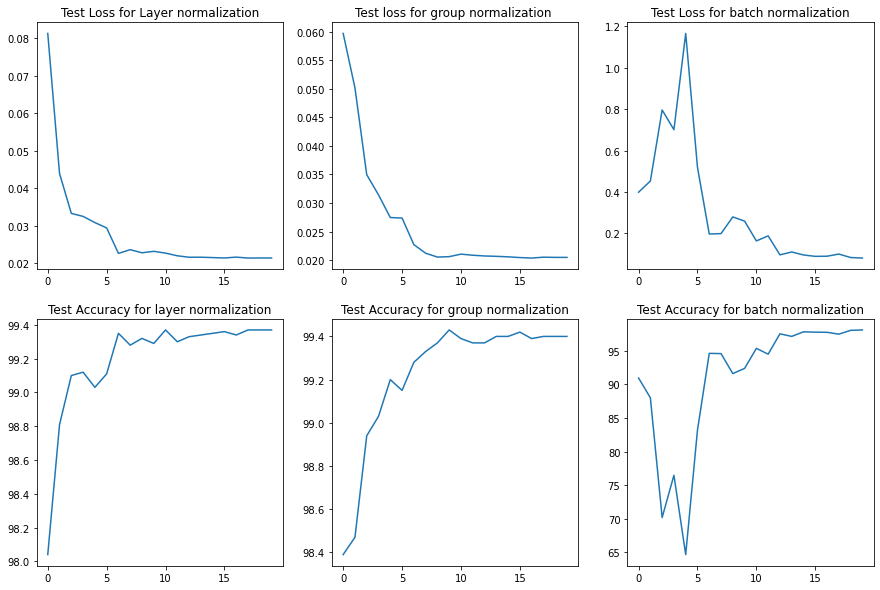

In [78]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
#t=[t.cpu().item() for t in test_losses]
axs[0, 0].plot(test_losses_layer)
axs[0, 0].set_title("Test Loss for Layer normalization")
axs[0, 1].plot(test_losses_group)
axs[0, 1].set_title("Test loss for group normalization ")
axs[0, 2].plot(test_losses_batch)
axs[0, 2].set_title("Test Loss for batch normalization")
axs[1, 0].plot(test_acc_layer)
axs[1, 0].set_title("Test Accuracy for layer normalization")
axs[1, 1].plot(test_acc_group)
axs[1, 1].set_title("Test Accuracy for group normalization")
axs[1, 2].plot(test_acc_batch)
axs[1, 2].set_title("Test Accuracy for batch normalization")

In [79]:
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []
#model_layer.eval()
for data,target in test_loader:
  data , target = data.to(device), target.to(device)
  output = model_layer(data) # shape = torch.Size([batch_size, 10])
  pred = output.argmax(dim=1, keepdim=True) #pred will be a 2d tensor of shape [batch_size,1]
  idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
  if idxs_mask.numel(): #if index masks is non-empty append the correspoding data value in incorrect examples
    incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
    incorrect_labels.append(target[idxs_mask].cpu().numpy()) #the corresponding target to the misclassified image
    incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy()) #the corresponiding predicted class of the misclassified image

In [ ]:
# fig = plt.figure(figsize=(20, 8))
# import numpy as np
# for idx in np.arange(10):
#     ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
#     #std = np.array([0.229, 0.224, 0.225])
#     #mean = np.array([0.485, 0.456, 0.406])
#     img = incorrect_examples[idx][idx]
#     img = img/2 + 0.5
#     img = np.clip(img, 0, 1)
#     plt.imshow(img)
#     ax.set_title(f"{images[pred[idx]]}: x%\n (label: {images[target[idx]]})",
#     color=("green" if pred[idx]==target[idx].item() else "red"))